In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
# from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
# from pytorch_lightning.loggers import TensorBoardLogger
# from torchmetrics import Accuracy
from sklearn.metrics import classification_report, confusion_matrix

# %matplotlib inline
# %config InlineBackend.figure_format='retina'
# sns.set(style='whitegrid', palette='muted')
# HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
# sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
# rcParams['figure.figsize'] = 3, 2

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
X_train = pd.read_csv("./data/career-con-2019/X_train.csv")
y_train = pd.read_csv("./data/career-con-2019/y_train.csv")

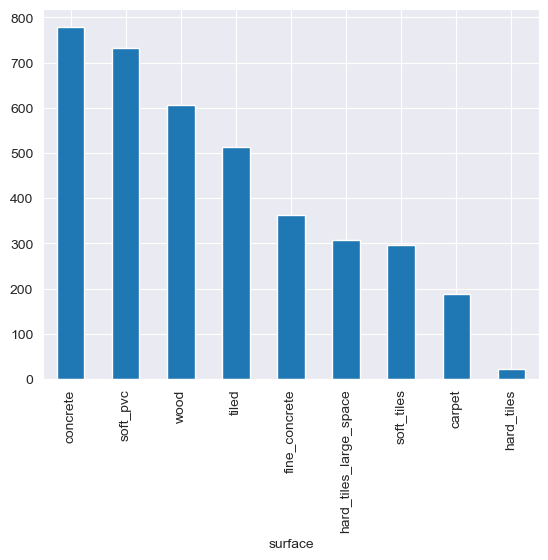

In [7]:
y_train.surface.value_counts().plot(kind='bar')

plt.show()
plt.close()

# Data Pre-processing

- **Integers to strings**

In [9]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)

for enc_label, label_name in zip(encoded_labels, label_encoder.classes_):
    print(f"Original Label -> encoded label: {label_name} -> {enc_label}")

Original Label -> encoded label: carpet -> 2
Original Label -> encoded label: concrete -> 1
Original Label -> encoded label: fine_concrete -> 1
Original Label -> encoded label: hard_tiles -> 1
Original Label -> encoded label: hard_tiles_large_space -> 6
Original Label -> encoded label: soft_pvc -> 7
Original Label -> encoded label: soft_tiles -> 5
Original Label -> encoded label: tiled -> 1
Original Label -> encoded label: wood -> 4


In [10]:
y_train["label"] = encoded_labels
y_train.head()

,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6


In [11]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [12]:
FEATURE_COLUMNS = X_train.columns.tolist()[3:]
FEATURE_COLUMNS

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

In [14]:
# Checking series or sequences are split or not
(X_train.series_id.value_counts() == 128).sum() == len(y_train)  # True

True

In [15]:
sequences = []
for series_id, group in X_train.groupby("series_id"):
    sequence_features = group[FEATURE_COLUMNS]
    label = y_train[y_train.series_id == series_id].iloc[0].label
    
    sequences.append((sequence_features, label))

In [16]:
sequences[0]

(     orientation_X  orientation_Y  orientation_Z  orientation_W  \
 0         -0.75853       -0.63435       -0.10488       -0.10597   
 1         -0.75853       -0.63434       -0.10490       -0.10600   
 2         -0.75853       -0.63435       -0.10492       -0.10597   
 3         -0.75852       -0.63436       -0.10495       -0.10597   
 4         -0.75852       -0.63435       -0.10495       -0.10596   
 ..             ...            ...            ...            ...   
 123       -0.75943       -0.63316       -0.10470       -0.10677   
 124       -0.75945       -0.63313       -0.10473       -0.10683   
 125       -0.75949       -0.63309       -0.10467       -0.10690   
 126       -0.75950       -0.63307       -0.10464       -0.10693   
 127       -0.75953       -0.63306       -0.10461       -0.10684   
 
      angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
 0              0.107650            0.017561            0.000767   
 1              0.067851            0.029939  

In [17]:
# Sequences are divided into train and test
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2)
print(len(train_sequences), len(test_sequences))

3048 762


# Creating dataset

In [19]:
class SurfaceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(sequence=torch.Tensor(sequence.to_numpy()), label=torch.tensor(label).long())

In [22]:
train_dataset = SurfaceDataset(train_sequences)
test_dataset = SurfaceDataset(test_sequences)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=cpu_count())
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=cpu_count())

# Model

In [24]:
class SequenceModel(nn.Module):
    def __init__(self, n_features, num_classes, n_hidden=128, n_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True, dropout=0.75)
        self.classifier = nn.Linear(n_hidden, num_classes)
    
    def forward(self, x):
        self.lstm.flatten_parameters()  # For Multi-GPU purposes we flatten parameters
        _, (hidden, _) = self.lstm(x)
        
        # Since it is the multi-layer net, take last output of the last state of the last layer
        out = hidden[-1]
        return self.classifier(out)
        

In [16]:
model = SequenceModel(n_features=n_features, num_classes=n_classes)
criterion = nn.CrossEntropyLoss()

output = model(x)
loss = 0
if labels is not None:
    loss = criterion(output, labels)
